# LIME interpretability for heartbeat classification with a convolutional neural network

In [4]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
sns.set()
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Flatten
length = 277
import lime
import lime.lime_tabular

### Extract task-specific data and one-hot encode labels

In [6]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_train.shape[1], 1)

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

Loading  ../../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Build the CNN architecture and train the model

In [10]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 10, 64
activationFunction='relu'

def getModel(): 
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(256, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()
cnnhistory= cnnmodel.fit(X_train, y_train, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 275, 128)          2176      
_________________________________________________________________
batch_normalization_2 (Batch (None, 275, 128)          512       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 275, 32)           65568     
_________________________________________________________________
batch_normalization_3 (Batch (None, 275, 32)           128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 275, 9)            4617      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 69, 9)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 621)              

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 35s 1ms/sample - loss: 0.3098 - accuracy: 0.8985 - val_loss: 0.2562 - val_accuracy: 0.9331
Epoch 2/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.1158 - accuracy: 0.9623 - val_loss: 0.0922 - val_accuracy: 0.9701
Epoch 3/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.0788 - accuracy: 0.9740 - val_loss: 0.0959 - val_accuracy: 0.9705
Epoch 4/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.0591 - accuracy: 0.9796 - val_loss: 0.0819 - val_accuracy: 0.9763
Epoch 5/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.0469 - accuracy: 0.9832 - val_loss: 0.0928 - val_accuracy: 0.9727
Epoch 6/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.0458 - accuracy: 0.9848 - val_loss: 0.0882 - val_accuracy: 0.9709
Epoch 7/10
25529/25529 [==============================] - 36s 1ms/sample - loss: 0.0396 - accuracy: 0.9862 - val_loss

In [12]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(cnnmodel, 'cnnmodel_lime_ecg.h5')

In [104]:
# Make a prediction and show the accuracy:
pred = cnnmodel.predict(X_test)
accuracy_score(np.argmax(y_test, axis = 1), np.argmax(pred, axis = 1))

0.9502152497160816

### Create the explainer and explain an instance

In [146]:
explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train, feature_names = ['x'], discretize_continuous = True)
exp = explainer.explain_instance(X_test1[50], cnnmodel.predict, labels = [np.argmax(y_test[50])], num_features = 275)

In [147]:
# Get the weights for all features:
map_explanation = exp.as_map()[np.argmax(y_test[50])]
features, weights = [], []
for e in map_explanation:
    features.append(e[0])
    weights.append(e[1])
features = np.array(features)
weights = np.array(weights)

# Sort based on features:
indices_sort = np.argsort(features)
features = features[indices_sort]
weights = weights[indices_sort]

# Average over the actual variables:
mean_weights = np.zeros((11, ))
for i in range(0, 275, 25):
    mean_weights[i // 25] = np.mean(weights[i:i+25])

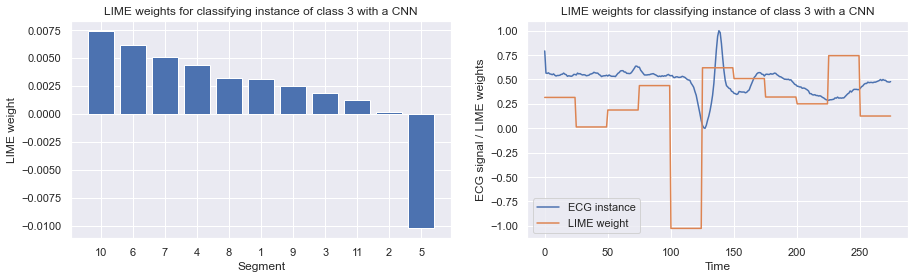

In [148]:
# Sort based on weight:
indices_sort = np.argsort(-1 * mean_weights)
slices = np.arange(1, 12)

# Visualize:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].bar(range(11), mean_weights[indices_sort])
ax[0].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[50])) + ' with a CNN')
ax[0].set_xticks(np.arange(11))
ax[0].set_xticklabels(slices[indices_sort])
ax[0].set_ylabel('LIME weight')
ax[0].set_xlabel('Segment')

ecg_normalized = (X_test1[50, :, 0] - X_test1[50, :, 0].min()) / (X_test1[50, :, 0].max() - X_test1[50, :, 0].min())
ax[1].plot(np.arange(275), ecg_normalized, label = 'ECG instance')
ax[1].plot(np.repeat(mean_weights * 100, 25), label = 'LIME weight')
ax[1].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[50])) + ' with a CNN')
ax[1].set_ylabel('ECG signal / LIME weights')
ax[1].set_xlabel('Time')
ax[1].legend()
plt.savefig('lime_weights_x50_CNN.jpg', dpi = 400)

### Explain another instance of another class

In [149]:
explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train, feature_names = ['x'], discretize_continuous = True)
exp = explainer.explain_instance(X_test1[100], cnnmodel.predict, labels = [np.argmax(y_test[100])], num_features = 275)

In [150]:
# Get the weights for all features:
map_explanation = exp.as_map()[np.argmax(y_test[100])]
features, weights = [], []
for e in map_explanation:
    features.append(e[0])
    weights.append(e[1])
features = np.array(features)
weights = np.array(weights)

# Sort based on features:
indices_sort = np.argsort(features)
features = features[indices_sort]
weights = weights[indices_sort]

# Average over the actual variables:
mean_weights = np.zeros((11, ))
for i in range(0, 275, 25):
    mean_weights[i // 25] = np.mean(weights[i:i+25])

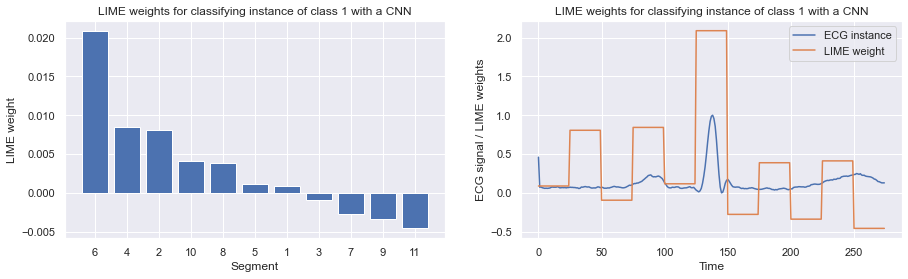

In [151]:
# Sort based on weight:
indices_sort = np.argsort(-1 * mean_weights)
slices = np.arange(1, 12)

# Visualize:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].bar(range(11), mean_weights[indices_sort])
ax[0].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[100])) + ' with a CNN')
ax[0].set_xticks(np.arange(11))
ax[0].set_xticklabels(slices[indices_sort])
ax[0].set_ylabel('LIME weight')
ax[0].set_xlabel('Segment')

ecg_normalized = (X_test1[100, :, 0] - X_test1[100, :, 0].min()) / (X_test1[100, :, 0].max() - X_test1[100, :, 0].min())
ax[1].plot(np.arange(275), ecg_normalized, label = 'ECG instance')
ax[1].plot(np.repeat(mean_weights * 100, 25), label = 'LIME weight')
ax[1].set_title('LIME weights for classifying instance of class ' + str(np.argmax(y_test[100])) + ' with a CNN')
ax[1].set_ylabel('ECG signal / LIME weights')
ax[1].set_xlabel('Time')
ax[1].legend()
plt.savefig('lime_weights_x100_CNN.jpg', dpi = 400)